# CWRU Bearing Fault Diagnosis with Spectrogram and Scalogram Inputs

This notebook implements a Convolutional Neural Network (CNN) for fault diagnosis of rolling element bearings using the Case Western Reserve University (CWRU) dataset. The methodology is based on Verstraete et al. (2017), which uses time-frequency image representations (spectrograms via STFT and scalograms via Morlet wavelet transform) as inputs to a CNN. The CNN architecture features double convolutional layers before pooling to enhance feature expressivity.


## Overview
- **Dataset**: CWRU Bearing Data (2HP load, various fault types and sizes)
- **Input**: 32x32 pixel spectrogram or scalogram images
- **Model**: CNN with three stages of double conv layers (32, 64, 128 filters), max pooling, and two dense layers
- **Training**: 5-fold stratified cross-validation with early stopping
- **Evaluation**: Accuracy, confusion matrices, and fold-wise performance plots

## Requirements
- Python libraries: tensorflow, numpy, scipy, scikit-learn, matplotlib, seaborn, pywt, skimage
- CWRU dataset files in 'CWRU_BearingData_Load_2HP' folder

Run cells sequentially to load data, preprocess, train the model, and evaluate results.

In [1]:
# Setup for Reproducibility
import tensorflow as tf
import numpy as np
import random
import os

# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Import additional libraries
import scipy.io
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from skimage.transform import resize
import pywt  # For wavelet transform

## Load CWRU Bearing Data

The `ImportData` function loads the CWRU dataset files (.mat) containing vibration signals for normal and fault conditions (inner race, ball, outer race) at various fault sizes under a 2HP load. The data is stored in a list for further processing.

In [2]:
def ImportData():
    folder_path = 'CWRU_BearingData_Load_1HP'
    file_paths = [
        os.path.join(folder_path, '98.mat'),
        os.path.join(folder_path, '110.mat'),
        os.path.join(folder_path, '123.mat'),
        os.path.join(folder_path, '136.mat'),
        os.path.join(folder_path, '175.mat'),
        os.path.join(folder_path, '190.mat'),
        os.path.join(folder_path, '202.mat'),
        os.path.join(folder_path, '214.mat'),
        os.path.join(folder_path, '227.mat'),
        os.path.join(folder_path, '239.mat')
    ]
    data_keys = [
        'X098_DE_time', 'X110_DE_time', 'X123_DE_time', 'X136_DE_time',
        'X175_DE_time', 'X190_DE_time', 'X202_DE_time', 'X214_DE_time',
        'X227_DE_time', 'X239_DE_time'
    ]
    data = [scipy.io.loadmat(fp)[key] for fp, key in zip(file_paths, data_keys)]
    return data



## Time-Frequency Image Generation

The following functions generate spectrogram and scalogram images from vibration signal segments, as per Verstraete et al. (2017):
- **Spectrogram**: Uses Short-Time Fourier Transform (STFT) with a Hann window, 256-point segments, and 128-point overlap. Images are normalized and resized to 32x32 pixels.
- **Scalogram**: Uses Continuous Wavelet Transform (CWT) with the Morlet wavelet, scales 1 to 128. Magnitude is normalized and resized to 32x32 pixels.

In [3]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape=(96, 96)):

    
    """
    Calculate the spectrogram of an array data_y_vector and resize it to image_shape.
    """
    fs = 48000
    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs,
        nperseg=256,
        # noverlap=128,
        window='hann'
    )
    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)
    return sxx

def generate_scalogram_image(data_y_vector, image_shape=(96,96)):
    """
    Calculate the scalogram using Morlet wavelet and resize it to image_shape.
    """
    fs = 48000
    scales = np.arange(1, 128)  # Adjust scales for Morlet wavelet
    coef, freqs = pywt.cwt(
        data_y_vector,
        scales,
        'morl',
        sampling_period=1/fs
    )
    coef = np.abs(coef)  # Use magnitude
    coef = min_max_norm(coef)
    coef = resize(coef, image_shape, mode='constant', anti_aliasing=True)
    return coef

## Data Preprocessing

The `Sampling` function segments the vibration signals into blocks, and `DataPreparation` generates spectrogram or scalogram images for each segment. Labels are created in one-hot encoded format (`Y_CNN`) for CNN training and as integers (`Y`) for stratification. The output is a 4D array of images and corresponding labels.

In [4]:
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(Data) - 2 * ignore_points
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block])
    for i in range(No_of_blocks):
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T
    return SplitData

def DataPreparation(Data, interval_length, samples_per_block, image_type='spectrogram'):
    """
    Prepare data by generating spectrogram or scalogram images.
    """
    X = []
    LabelPositional = []
    Label = []
    for count, data in enumerate(Data):
        SplitData = Sampling(data, interval_length, samples_per_block)
        images = []
        for segment in SplitData:
            if image_type == 'spectrogram':
                img = generate_spectrogram_image(segment)
            elif image_type == 'scalogram':
                img = generate_scalogram_image(segment)
            images.append(img)
        images = np.array(images)
        y = np.zeros([len(SplitData), 10])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        X.append(images)
        LabelPositional.append(y)
        Label.append(y1)
    X = np.concatenate(X, axis=0)
    LabelPositional = np.concatenate(LabelPositional, axis=0)
    Label = np.concatenate(Label, axis=0)
    return X, LabelPositional, Label

## CNN Model Definition

The `CNN_2D` class defines the CNN architecture as per Verstraete et al. (2017):
- Three stages, each with two convolutional layers (32, 64, 128 filters, 3x3 kernels) followed by 2x2 max pooling.
- Two dense layers (100 units each) with dropout (0.5) before the second dense layer.
- Output layer with 10 units (softmax) for 10-class classification.
- Compiled with Adam optimizer and categorical crossentropy loss.

In [5]:
class CNN_2D():
    def __init__(self):
        self.model = self.CreateModel()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 1)),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(96, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

## Main Execution

This section executes the pipeline:
- Loads and preprocesses data to generate 96x96 images (spectrogram or scalogram).
- Splits data into training (80%) and test (20%) sets with stratification.
- Performs 5-fold cross-validation with early stopping and model checkpointing.
- Saves the best model for each fold.

**Parameters**:
- `image_type`: Set to 'scalogram' or 'spectrogram' to choose input type.
- `image_shape`: 96x96 pixels for high accuracy (per Verstraete et al.).
- `kSplits`: 5 for cross-validation.
- `foldername`: Directory to save model checkpoints.

In [6]:
# Parameters
interval_length = 1600
samples_per_block = 1600
image_type = 'spectrogram'  # Change to 'spectrogram' to use spectrograms
image_shape = (96,96)
kSplits = 5
foldername = "CNN2D_results/Spectrogram-96x96-NO/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

# Load and prepare data
Data = ImportData()
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block, image_type=image_type)
Input_2D = X.reshape([-1, image_shape[0], image_shape[1], 1])
print(f"Shape of Input Data: {Input_2D.shape}")

# Train-test split
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(
    Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y
)

Shape of Input Data: (2954, 96, 96, 1)


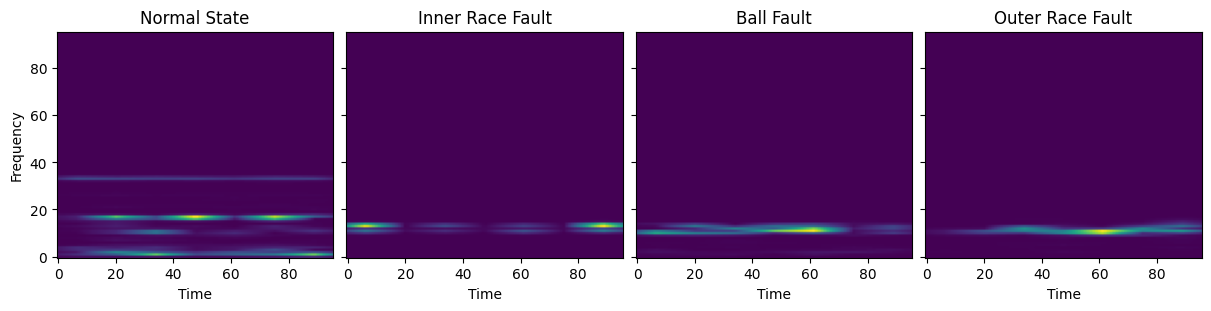

In [7]:
# Create a figure with four subplots, sharing the y-axis
fig, (plt1, plt2, plt3, plt4) = plt.subplots(1, 4, sharey=True, figsize=(12, 3), constrained_layout=True)

# Plot Normal state spectrogram (index 0, assuming Normal samples are at the start)
plt1.set_xlabel("Time")
plt1.set_ylabel("Frequency")
plt1.set_title('Normal State')
plt1.imshow(Input_2D[0, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Inner Race fault spectrogram (index 1000, assuming Inner Race samples around this index)
plt2.set_xlabel("Time")
plt2.set_title('Inner Race Fault')
plt2.imshow(Input_2D[1000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Ball fault spectrogram (index 2000, assuming Ball fault samples around this index)
plt3.set_xlabel("Time")
plt3.set_title('Ball Fault')
plt3.imshow(Input_2D[2000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Outer Race fault spectrogram (index 2500, assuming Outer Race samples around this index)
plt4.set_xlabel("Time")
plt4.set_title('Outer Race Fault')
plt4.imshow(Input_2D[2500, :, :], aspect='auto', origin='lower', cmap='viridis')

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# K-fold cross-validation
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True)
accuracy_train = []
accuracy_val = []
accuracy_test = []
precision_val = []
recall_val = []
f1_val = []
pred_all_val = np.zeros([len(X_2D_train), 10])
y_2D_val = np.zeros([len(X_2D_train), 10])
kfold_test_len = []
fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Train the model
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):
    checkpoint_filepath = foldername + f"best_model_{k}.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    Classification_2D = CNN_2D()
    history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )
    print(f"Best model saved at: {checkpoint_filepath}")
    CNN_2D_best_model = load_model(checkpoint_filepath)
    print("Best model loaded successfully!")
    
    fl2 = fl1 + len(test)
    pred_all_val[fl1:fl2, :] = CNN_2D_best_model.predict(X_2D_train[test])
    y_2D_val[fl1:fl2, :] = y_2D_train[test]
    kfold_test_len.append(fl2 - fl1)
    fl1 = fl2

    train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train])
    accuracy_train.append(train_accuracy)
    val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test])
    accuracy_val.append(val_accuracy)
    test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test)
    accuracy_test.append(test_accuracy)

    # Calculate precision, recall, and F1 score for validation set
    y_pred_val = np.argmax(CNN_2D_best_model.predict(X_2D_train[test]), axis=1)
    y_true_val = np.argmax(y_2D_train[test], axis=1)
    precision_val.append(precision_score(y_true_val, y_pred_val, average='weighted'))
    recall_val.append(recall_score(y_true_val, y_pred_val, average='weighted'))
    f1_val.append(f1_score(y_true_val, y_pred_val, average='weighted'))


    
    k += 1

/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 10:42:32.577189: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 10:42:32.577508: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1851 - loss: 2.0950

2025-06-17 10:43:50.135245: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 10:43:50.136463: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.69133, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.1877 - loss: 2.0891 - val_accuracy: 0.6913 - val_loss: 0.8550
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6325 - loss: 0.9416
Epoch 2: val_accuracy improved from 0.69133 to 0.73573, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.6328 - loss: 0.9405 - val_accuracy: 0.7357 - val_loss: 0.5705
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6914 - loss: 0.7472
Epoch 3: val_accuracy improved from 0.73573 to 0.77167, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6919 - loss: 0.7460 - val_accuracy: 0.7717 - val_loss: 0.4859
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7765 - loss: 0.5353
Epoch 4: val_accuracy improved from 0.77167 to 0.80973, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7767 - loss: 0.5349 - val_accuracy: 0.8097 - val_loss: 0.4141
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8243 - loss: 0.4198
Epoch 5: val_accuracy improved from 0.80973 to 0.84144, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8244 - loss: 0.4198 - val_accuracy: 0.8414 - val_loss: 0.3156
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8422 - loss: 0.3841
Epoch 6: val_accuracy did not improve from 0.84144
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8423 - loss: 0.3839 - val_accuracy: 0.8351 - val_loss: 0.3712
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8697 - loss: 0.3520
Epoch 7: val_accuracy improved from 0.84144 to 0.87315, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8699 - loss: 0.3513 - val_accuracy: 0.8732 - val_loss: 0.3430
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8809 - loss: 0.3463
Epoch 8: val_accuracy improved from 0.87315 to 0.89852, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8810 - loss: 0.3457 - val_accuracy: 0.8985 - val_loss: 0.2943
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8948 - loss: 0.2819
Epoch 9: val_accuracy improved from 0.89852 to 0.92178, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8949 - loss: 0.2818 - val_accuracy: 0.9218 - val_loss: 0.2372
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9089 - loss: 0.2663
Epoch 10: val_accuracy improved from 0.92178 to 0.94292, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9089 - loss: 0.2662 - val_accuracy: 0.9429 - val_loss: 0.1592
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8861 - loss: 0.3065
Epoch 11: val_accuracy did not improve from 0.94292
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8861 - loss: 0.3063 - val_accuracy: 0.9345 - val_loss: 0.2108
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9321 - loss: 0.1956
Epoch 12: val_accuracy did not improve from 0.94292
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9320 - loss: 0.1959 - val_accuracy: 0.9302 - val_loss: 0.2285
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9288 - loss: 0.1949
Epoch 13: val_accuracy improved from 0.94292 to 0.95349, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9288 - loss: 0.1949 - val_accuracy: 0.9535 - val_loss: 0.1267
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9279 - loss: 0.2010
Epoch 14: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9280 - loss: 0.2009 - val_accuracy: 0.9387 - val_loss: 0.2122
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9054 - loss: 0.2866
Epoch 15: val_accuracy improved from 0.95349 to 0.95560, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9054 - loss: 0.2863 - val_accuracy: 0.9556 - val_loss: 0.1559
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9471 - loss: 0.1477
Epoch 16: val_accuracy improved from 0.95560 to 0.97252, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9471 - loss: 0.1477 - val_accuracy: 0.9725 - val_loss: 0.0973
Epoch 17/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9550 - loss: 0.1281
Epoch 17: val_accuracy did not improve from 0.97252
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9549 - loss: 0.1281 - val_accuracy: 0.9577 - val_loss: 0.1165
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9539 - loss: 0.1162
Epoch 18: val_accuracy improved from 0.97252 to 0.97674, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9540 - loss: 0.1162 - val_accuracy: 0.9767 - val_loss: 0.0911
Epoch 19/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9645 - loss: 0.1095
Epoch 19: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9644 - loss: 0.1096 - val_accuracy: 0.9662 - val_loss: 0.1373
Epoch 20/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9678 - loss: 0.0935
Epoch 20: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9676 - loss: 0.0937 - val_accuracy: 0.9598 - val_loss: 0.1202
Epoch 21/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9648 - loss: 0.1034
Epoch 21: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9647 - loss: 0.1035 - val_accuracy: 0.9641 - val_loss: 0.1047
Epoch 22/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9678 - loss: 0.1152
Epoch 22: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9848 - loss: 0.0399 - val_accuracy: 0.9789 - val_loss: 0.0710
Epoch 32/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9778 - loss: 0.0651
Epoch 32: val_accuracy did not improve from 0.97886
60/60 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9778 - loss: 0.0651 - val_accuracy: 0.9619 - val_loss: 0.1151
Epoch 33/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9715 - loss: 0.0733
Epoch 33: val_accuracy improved from 0.97886 to 0.98309, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9715 - loss: 0.0734 - val_accuracy: 0.9831 - val_loss: 0.0700
Epoch 34/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9788 - loss: 0.0625
Epoch 34: val_accuracy did not improve from 0.98309
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9788 - loss: 0.0625 - val_accuracy: 0.9746 - val_loss: 0.1255
Epoch 35/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9718 - loss: 0.0695
Epoch 35: val_accuracy did not improve from 0.98309
60/60 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9718 - loss: 0.0695 - val_accuracy: 0.9810 - val_loss: 0.0653
Epoch 36/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9823 - loss: 0.0510
Epoch 36: val_accuracy did not improve from 0.98309
60/60 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9822 - loss: 0.0513 - val_accuracy: 0.9789 - val_loss: 0.0814
Epoch 37/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9825 - loss: 0.0551
Epoch 37: val_accuracy did not improve fro

60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9741 - loss: 0.0909 - val_accuracy: 0.9852 - val_loss: 0.0454
Epoch 49/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9880 - loss: 0.0341
Epoch 49: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9880 - loss: 0.0341 - val_accuracy: 0.9683 - val_loss: 0.1418
Epoch 50/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9828 - loss: 0.0524
Epoch 50: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9826 - loss: 0.0529 - val_accuracy: 0.9746 - val_loss: 0.0992
Epoch 51/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9729 - loss: 0.0981
Epoch 51: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9728 - loss: 0.0989 - val_accuracy: 0.9556 - val_loss: 0.1829
Epoch 52/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9393 - loss: 0.2159
Epoch 52: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9884 - loss: 0.0343 - val_accuracy: 0.9894 - val_loss: 0.0507
Epoch 57/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9820 - loss: 0.0599
Epoch 57: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9818 - loss: 0.0602 - val_accuracy: 0.9789 - val_loss: 0.0857
Epoch 58/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9877 - loss: 0.0421
Epoch 58: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9878 - loss: 0.0420 - val_accuracy: 0.9810 - val_loss: 0.0870
Epoch 59/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9890 - loss: 0.0326
Epoch 59: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9890 - loss: 0.0326 - val_accuracy: 0.9852 - val_loss: 0.0624
Epoch 60/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9844 - loss: 0.0385
Epoch 60: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9919 - loss: 0.0330 - val_accuracy: 0.9915 - val_loss: 0.0425
Epoch 65/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9957 - loss: 0.0159
Epoch 65: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9957 - loss: 0.0159 - val_accuracy: 0.9894 - val_loss: 0.0512
Epoch 66/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9836 - loss: 0.0546
Epoch 66: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9836 - loss: 0.0547 - val_accuracy: 0.9852 - val_loss: 0.0670
Epoch 67/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9895 - loss: 0.0394
Epoch 67: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9896 - loss: 0.0392 - val_accuracy: 0.9915 - val_loss: 0.0519
Epoch 68/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9924 - loss: 0.0267
Epoch 68: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-17 13:58:20.519586: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 13:58:20.520103: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step


2025-06-17 13:58:29.556583: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 13:58:29.557294: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 413ms/step - accuracy: 1.0000 - loss: 0.0013


2025-06-17 13:58:54.844075: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 13:58:54.844420: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.9901 - loss: 0.0451


2025-06-17 13:59:01.337380: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 13:59:01.337732: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 408ms/step - accuracy: 0.9821 - loss: 0.0536


2025-06-17 13:59:09.171508: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 13:59:09.172084: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 13:59:15.810515: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 13:59:15.810930: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2513 - loss: 1.9732

2025-06-17 14:00:42.008064: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 14:00:42.008786: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.63002, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.2534 - loss: 1.9672 - val_accuracy: 0.6300 - val_loss: 0.8932
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6323 - loss: 0.9442
Epoch 2: val_accuracy improved from 0.63002 to 0.73362, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6327 - loss: 0.9424 - val_accuracy: 0.7336 - val_loss: 0.5133
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7000 - loss: 0.7332
Epoch 3: val_accuracy improved from 0.73362 to 0.82875, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7002 - loss: 0.7326 - val_accuracy: 0.8288 - val_loss: 0.3770
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7787 - loss: 0.5295
Epoch 4: val_accuracy improved from 0.82875 to 0.83298, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7786 - loss: 0.5294 - val_accuracy: 0.8330 - val_loss: 0.3317
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8233 - loss: 0.4341
Epoch 5: val_accuracy did not improve from 0.83298
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8232 - loss: 0.4340 - val_accuracy: 0.7970 - val_loss: 0.4191
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8108 - loss: 0.4721
Epoch 6: val_accuracy improved from 0.83298 to 0.86681, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8108 - loss: 0.4719 - val_accuracy: 0.8668 - val_loss: 0.2688
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8381 - loss: 0.3641
Epoch 7: val_accuracy improved from 0.86681 to 0.86892, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8381 - loss: 0.3642 - val_accuracy: 0.8689 - val_loss: 0.2610
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8541 - loss: 0.3158
Epoch 8: val_accuracy improved from 0.86892 to 0.90063, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8540 - loss: 0.3161 - val_accuracy: 0.9006 - val_loss: 0.2271
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8853 - loss: 0.2889
Epoch 9: val_accuracy improved from 0.90063 to 0.93023, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8852 - loss: 0.2891 - val_accuracy: 0.9302 - val_loss: 0.1891
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9055 - loss: 0.2401
Epoch 10: val_accuracy did not improve from 0.93023
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9054 - loss: 0.2403 - val_accuracy: 0.8393 - val_loss: 0.3343
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8938 - loss: 0.2732
Epoch 11: val_accuracy did not improve from 0.93023
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8938 - loss: 0.2733 - val_accuracy: 0.8520 - val_loss: 0.3162
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8980 - loss: 0.2672
Epoch 12: val_accuracy improved from 0.93023 to 0.93446, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8980 - loss: 0.2670 - val_accuracy: 0.9345 - val_loss: 0.1574
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9240 - loss: 0.1998
Epoch 13: val_accuracy did not improve from 0.93446
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9241 - loss: 0.1997 - val_accuracy: 0.9281 - val_loss: 0.1678
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9516 - loss: 0.1450
Epoch 14: val_accuracy improved from 0.93446 to 0.97040, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9515 - loss: 0.1453 - val_accuracy: 0.9704 - val_loss: 0.0987
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9461 - loss: 0.1191
Epoch 15: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9461 - loss: 0.1192 - val_accuracy: 0.9662 - val_loss: 0.0926
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9352 - loss: 0.1666
Epoch 16: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9352 - loss: 0.1666 - val_accuracy: 0.9218 - val_loss: 0.2736
Epoch 17/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9464 - loss: 0.1838
Epoch 17: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9464 - loss: 0.1834 - val_accuracy: 0.9641 - val_loss: 0.1117
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9609 - loss: 0.1002
Epoch 18: val_accuracy did not improve from

60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9571 - loss: 0.1171 - val_accuracy: 0.9852 - val_loss: 0.0545
Epoch 21/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9731 - loss: 0.0706
Epoch 21: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9731 - loss: 0.0707 - val_accuracy: 0.9662 - val_loss: 0.0812
Epoch 22/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9609 - loss: 0.1134
Epoch 22: val_accuracy improved from 0.98520 to 0.98731, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9608 - loss: 0.1136 - val_accuracy: 0.9873 - val_loss: 0.0346
Epoch 23/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9723 - loss: 0.0740
Epoch 23: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9722 - loss: 0.0742 - val_accuracy: 0.9767 - val_loss: 0.0811
Epoch 24/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9606 - loss: 0.1093
Epoch 24: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9605 - loss: 0.1094 - val_accuracy: 0.9852 - val_loss: 0.0402
Epoch 25/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9785 - loss: 0.0588
Epoch 25: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9784 - loss: 0.0589 - val_accuracy: 0.9810 - val_loss: 0.0944
Epoch 26/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9736 - loss: 0.0793
Epoch 26: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9493 - loss: 0.1193 - val_accuracy: 0.9894 - val_loss: 0.0407
Epoch 28/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9799 - loss: 0.0557
Epoch 28: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9798 - loss: 0.0559 - val_accuracy: 0.9852 - val_loss: 0.0470
Epoch 29/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9765 - loss: 0.0656
Epoch 29: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9766 - loss: 0.0657 - val_accuracy: 0.9746 - val_loss: 0.0735
Epoch 30/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9756 - loss: 0.0696
Epoch 30: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9756 - loss: 0.0695 - val_accuracy: 0.9894 - val_loss: 0.0219
Epoch 31/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9759 - loss: 0.0661
Epoch 31: val_accuracy improved from 0.9894

60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9759 - loss: 0.0662 - val_accuracy: 0.9915 - val_loss: 0.0307
Epoch 32/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9762 - loss: 0.0772
Epoch 32: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9761 - loss: 0.0777 - val_accuracy: 0.9725 - val_loss: 0.0754
Epoch 33/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9771 - loss: 0.0688
Epoch 33: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9771 - loss: 0.0690 - val_accuracy: 0.9873 - val_loss: 0.0322
Epoch 34/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9765 - loss: 0.0808
Epoch 34: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9765 - loss: 0.0810 - val_accuracy: 0.9789 - val_loss: 0.0543
Epoch 35/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9841 - loss: 0.0583
Epoch 35: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9860 - loss: 0.0313 - val_accuracy: 0.9958 - val_loss: 0.0208
Epoch 40/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9918 - loss: 0.0224
Epoch 40: val_accuracy did not improve from 0.99577
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9918 - loss: 0.0226 - val_accuracy: 0.9789 - val_loss: 0.0707
Epoch 41/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9836 - loss: 0.0518
Epoch 41: val_accuracy did not improve from 0.99577
60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9836 - loss: 0.0518 - val_accuracy: 0.9915 - val_loss: 0.0416
Epoch 42/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9902 - loss: 0.0423
Epoch 42: val_accuracy did not improve from 0.99577
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9900 - loss: 0.0426 - val_accuracy: 0.9831 - val_loss: 0.0730
Epoch 43/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9743 - loss: 0.0705
Epoch 43: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9859 - loss: 0.0321 - val_accuracy: 0.9979 - val_loss: 0.0152
Epoch 50/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9915 - loss: 0.0263
Epoch 50: val_accuracy did not improve from 0.99789
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9915 - loss: 0.0264 - val_accuracy: 0.9873 - val_loss: 0.0435
Epoch 51/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9861 - loss: 0.0410
Epoch 51: val_accuracy did not improve from 0.99789
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9861 - loss: 0.0410 - val_accuracy: 0.9894 - val_loss: 0.0228
Epoch 52/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9851 - loss: 0.0444
Epoch 52: val_accuracy did not improve from 0.99789
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9851 - loss: 0.0443 - val_accuracy: 0.9937 - val_loss: 0.0123
Epoch 53/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9932 - loss: 0.0131
Epoch 53: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-17 16:35:38.170959: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 16:35:38.171888: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step


2025-06-17 16:35:44.754035: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:35:44.754394: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 411ms/step - accuracy: 1.0000 - loss: 0.0023


2025-06-17 16:36:09.688601: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:36:09.688903: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.9991 - loss: 0.0101


2025-06-17 16:36:15.801802: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:36:15.802154: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - accuracy: 0.9868 - loss: 0.0497


2025-06-17 16:36:23.510224: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 16:36:23.510582: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 16:36:29.782393: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:36:29.782780: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2382 - loss: 2.0295

2025-06-17 16:37:50.676249: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:37:50.676696: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.63214, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.2402 - loss: 2.0240 - val_accuracy: 0.6321 - val_loss: 0.8704
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6269 - loss: 0.9379
Epoch 2: val_accuracy improved from 0.63214 to 0.75264, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6274 - loss: 0.9364 - val_accuracy: 0.7526 - val_loss: 0.5210
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7342 - loss: 0.6247
Epoch 3: val_accuracy improved from 0.75264 to 0.84989, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7344 - loss: 0.6245 - val_accuracy: 0.8499 - val_loss: 0.3931
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7930 - loss: 0.5050
Epoch 4: val_accuracy did not improve from 0.84989
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7930 - loss: 0.5047 - val_accuracy: 0.8288 - val_loss: 0.3504
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8169 - loss: 0.4406
Epoch 5: val_accuracy did not improve from 0.84989
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8168 - loss: 0.4404 - val_accuracy: 0.8140 - val_loss: 0.4952
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8149 - loss: 0.4181
Epoch 6: val_accuracy improved from 0.84989 to 0.88372, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8151 - loss: 0.4176 - val_accuracy: 0.8837 - val_loss: 0.2410
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8496 - loss: 0.3555
Epoch 7: val_accuracy improved from 0.88372 to 0.90275, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8496 - loss: 0.3555 - val_accuracy: 0.9027 - val_loss: 0.2398
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8613 - loss: 0.3319
Epoch 8: val_accuracy improved from 0.90275 to 0.90909, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8614 - loss: 0.3316 - val_accuracy: 0.9091 - val_loss: 0.2086
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8648 - loss: 0.3196
Epoch 9: val_accuracy did not improve from 0.90909
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8649 - loss: 0.3194 - val_accuracy: 0.8985 - val_loss: 0.2498
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8873 - loss: 0.2631
Epoch 10: val_accuracy improved from 0.90909 to 0.92178, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8874 - loss: 0.2631 - val_accuracy: 0.9218 - val_loss: 0.2056
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9301 - loss: 0.2078
Epoch 11: val_accuracy improved from 0.92178 to 0.93235, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9300 - loss: 0.2079 - val_accuracy: 0.9323 - val_loss: 0.2045
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9068 - loss: 0.2431
Epoch 12: val_accuracy improved from 0.93235 to 0.95349, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9069 - loss: 0.2428 - val_accuracy: 0.9535 - val_loss: 0.1651
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9312 - loss: 0.1761
Epoch 13: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9311 - loss: 0.1765 - val_accuracy: 0.9493 - val_loss: 0.1896
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9357 - loss: 0.1770
Epoch 14: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9357 - loss: 0.1772 - val_accuracy: 0.9154 - val_loss: 0.2134
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9064 - loss: 0.3117
Epoch 15: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9066 - loss: 0.3106 - val_accuracy: 0.9302 - val_loss: 0.1737
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9360 - loss: 0.1805
Epoch 16: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9558 - loss: 0.1317 - val_accuracy: 0.9767 - val_loss: 0.1070
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9636 - loss: 0.1328
Epoch 18: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9636 - loss: 0.1326 - val_accuracy: 0.9662 - val_loss: 0.1290
Epoch 19/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9447 - loss: 0.1601
Epoch 19: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9448 - loss: 0.1597 - val_accuracy: 0.9704 - val_loss: 0.1282
Epoch 20/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9619 - loss: 0.1065
Epoch 20: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9617 - loss: 0.1069 - val_accuracy: 0.9535 - val_loss: 0.1770
Epoch 21/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9534 - loss: 0.1326
Epoch 21: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9633 - loss: 0.0981 - val_accuracy: 0.9873 - val_loss: 0.0494
Epoch 32/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9693 - loss: 0.0696
Epoch 32: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9694 - loss: 0.0695 - val_accuracy: 0.9598 - val_loss: 0.2216
Epoch 33/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9765 - loss: 0.0712
Epoch 33: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9766 - loss: 0.0711 - val_accuracy: 0.9450 - val_loss: 0.2263
Epoch 34/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9390 - loss: 0.2064
Epoch 34: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9392 - loss: 0.2059 - val_accuracy: 0.9767 - val_loss: 0.0830
Epoch 35/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9697 - loss: 0.0845
Epoch 35: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9798 - loss: 0.0860 - val_accuracy: 0.9894 - val_loss: 0.0460
Epoch 47/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9888 - loss: 0.0422
Epoch 47: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9887 - loss: 0.0423 - val_accuracy: 0.9831 - val_loss: 0.0841
Epoch 48/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9885 - loss: 0.0404
Epoch 48: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9885 - loss: 0.0405 - val_accuracy: 0.9831 - val_loss: 0.0582
Epoch 49/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9892 - loss: 0.0331
Epoch 49: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9892 - loss: 0.0332 - val_accuracy: 0.9873 - val_loss: 0.0464
Epoch 50/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9886 - loss: 0.0475
Epoch 50: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9878 - loss: 0.0360 - val_accuracy: 0.9915 - val_loss: 0.0348
Epoch 59/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9900 - loss: 0.0235
Epoch 59: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9900 - loss: 0.0235 - val_accuracy: 0.9831 - val_loss: 0.0711
Epoch 60/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9919 - loss: 0.0325
Epoch 60: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9918 - loss: 0.0327 - val_accuracy: 0.9831 - val_loss: 0.0537
Epoch 61/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9835 - loss: 0.0426
Epoch 61: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9836 - loss: 0.0425 - val_accuracy: 0.9852 - val_loss: 0.0709
Epoch 62/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9920 - loss: 0.0272
Epoch 62: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9751 - loss: 0.0865 - val_accuracy: 0.9937 - val_loss: 0.0376
Epoch 79/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9957 - loss: 0.0107
Epoch 79: val_accuracy did not improve from 0.99366
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9957 - loss: 0.0107 - val_accuracy: 0.9873 - val_loss: 0.0811
Epoch 80/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9945 - loss: 0.0195
Epoch 80: val_accuracy did not improve from 0.99366
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9944 - loss: 0.0197 - val_accuracy: 0.9873 - val_loss: 0.0712
Epoch 81/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9859 - loss: 0.0469
Epoch 81: val_accuracy did not improve from 0.99366
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9859 - loss: 0.0472 - val_accuracy: 0.9810 - val_loss: 0.0623
Epoch 82/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9910 - loss: 0.0400
Epoch 82: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9964 - loss: 0.0110 - val_accuracy: 0.9958 - val_loss: 0.0298
Epoch 118/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9936 - loss: 0.0171
Epoch 118: val_accuracy did not improve from 0.99577
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9936 - loss: 0.0170 - val_accuracy: 0.9958 - val_loss: 0.0254
Epoch 119/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9964 - loss: 0.0088
Epoch 119: val_accuracy did not improve from 0.99577
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9964 - loss: 0.0088 - val_accuracy: 0.9810 - val_loss: 0.1377
Epoch 120/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9969 - loss: 0.0095
Epoch 120: val_accuracy did not improve from 0.99577
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9969 - loss: 0.0095 - val_accuracy: 0.9789 - val_loss: 0.1001
Epoch 121/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9932 - loss: 0.0210
Epoch 121: val_accuracy did not impro

Best model loaded successfully!


2025-06-17 20:54:18.448587: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 20:54:18.449150: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step


2025-06-17 20:54:25.133009: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:54:25.133396: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 437ms/step - accuracy: 1.0000 - loss: 3.5917e-04


2025-06-17 20:54:51.750524: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:54:51.750820: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.9980 - loss: 0.0267


2025-06-17 20:54:58.524702: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:54:58.525090: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step - accuracy: 0.9862 - loss: 0.0768


2025-06-17 20:55:06.388153: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 20:55:06.388483: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 20:55:12.820312: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:55:12.820637: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1766 - loss: 2.1244

2025-06-17 20:56:37.726709: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:56:37.727285: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.60381, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.1789 - loss: 2.1192 - val_accuracy: 0.6038 - val_loss: 1.0216
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5919 - loss: 1.0563
Epoch 2: val_accuracy improved from 0.60381 to 0.79237, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5926 - loss: 1.0542 - val_accuracy: 0.7924 - val_loss: 0.4764
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7344 - loss: 0.6595
Epoch 3: val_accuracy improved from 0.79237 to 0.86441, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7344 - loss: 0.6590 - val_accuracy: 0.8644 - val_loss: 0.3262
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7830 - loss: 0.5499
Epoch 4: val_accuracy did not improve from 0.86441
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7831 - loss: 0.5496 - val_accuracy: 0.8008 - val_loss: 0.4549
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7976 - loss: 0.4670 
Epoch 5: val_accuracy did not improve from 0.86441
60/60 ━━━━━━━━━━━━━━━━━━━━ 1090s 18s/step - accuracy: 0.7978 - loss: 0.4665 - val_accuracy: 0.8030 - val_loss: 0.4764
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7788 - loss: 0.5322
Epoch 6: val_accuracy improved from 0.86441 to 0.87500, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7793 - loss: 0.5311 - val_accuracy: 0.8750 - val_loss: 0.2760
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8173 - loss: 0.4413
Epoch 7: val_accuracy did not improve from 0.87500
60/60 ━━━━━━━━━━━━━━━━━━━━ 402s 7s/step - accuracy: 0.8175 - loss: 0.4408 - val_accuracy: 0.8686 - val_loss: 0.3165
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8484 - loss: 0.3520
Epoch 8: val_accuracy improved from 0.87500 to 0.89195, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8486 - loss: 0.3516 - val_accuracy: 0.8919 - val_loss: 0.2219
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8848 - loss: 0.3194
Epoch 9: val_accuracy improved from 0.89195 to 0.89407, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8847 - loss: 0.3196 - val_accuracy: 0.8941 - val_loss: 0.2383
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8589 - loss: 0.3872
Epoch 10: val_accuracy improved from 0.89407 to 0.95551, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8592 - loss: 0.3862 - val_accuracy: 0.9555 - val_loss: 0.1143
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8923 - loss: 0.2587
Epoch 11: val_accuracy did not improve from 0.95551
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8924 - loss: 0.2589 - val_accuracy: 0.9428 - val_loss: 0.1504
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9094 - loss: 0.2294
Epoch 12: val_accuracy did not improve from 0.95551
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9096 - loss: 0.2291 - val_accuracy: 0.9555 - val_loss: 0.1105
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9162 - loss: 0.2276
Epoch 13: val_accuracy did not improve from 0.95551
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9160 - loss: 0.2279 - val_accuracy: 0.9089 - val_loss: 0.2377
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9144 - loss: 0.2440
Epoch 14: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9376 - loss: 0.1845 - val_accuracy: 0.9661 - val_loss: 0.0895
Epoch 17/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9517 - loss: 0.1185
Epoch 17: val_accuracy did not improve from 0.96610
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9516 - loss: 0.1188 - val_accuracy: 0.8496 - val_loss: 0.7150
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9112 - loss: 0.2551
Epoch 18: val_accuracy did not improve from 0.96610
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9114 - loss: 0.2544 - val_accuracy: 0.9513 - val_loss: 0.1205
Epoch 19/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9486 - loss: 0.1494
Epoch 19: val_accuracy did not improve from 0.96610
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9486 - loss: 0.1494 - val_accuracy: 0.9555 - val_loss: 0.0942
Epoch 20/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9556 - loss: 0.1362
Epoch 20: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9613 - loss: 0.1337 - val_accuracy: 0.9682 - val_loss: 0.0764
Epoch 22/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9669 - loss: 0.0924
Epoch 22: val_accuracy improved from 0.96822 to 0.98305, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9669 - loss: 0.0924 - val_accuracy: 0.9831 - val_loss: 0.0388
Epoch 23/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9622 - loss: 0.1015
Epoch 23: val_accuracy did not improve from 0.98305
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9621 - loss: 0.1016 - val_accuracy: 0.9809 - val_loss: 0.0571
Epoch 24/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9439 - loss: 0.1690
Epoch 24: val_accuracy did not improve from 0.98305
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9438 - loss: 0.1691 - val_accuracy: 0.9767 - val_loss: 0.0610
Epoch 25/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9684 - loss: 0.0898
Epoch 25: val_accuracy did not improve from 0.98305
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9684 - loss: 0.0898 - val_accuracy: 0.9767 - val_loss: 0.0613
Epoch 26/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9683 - loss: 0.1172
Epoch 26: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9655 - loss: 0.0945 - val_accuracy: 0.9852 - val_loss: 0.0346
Epoch 28/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9757 - loss: 0.0677
Epoch 28: val_accuracy improved from 0.98517 to 0.99153, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9757 - loss: 0.0678 - val_accuracy: 0.9915 - val_loss: 0.0264
Epoch 29/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9665 - loss: 0.0878
Epoch 29: val_accuracy did not improve from 0.99153
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9665 - loss: 0.0876 - val_accuracy: 0.9873 - val_loss: 0.0273
Epoch 30/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9661 - loss: 0.0930
Epoch 30: val_accuracy did not improve from 0.99153
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9661 - loss: 0.0929 - val_accuracy: 0.9788 - val_loss: 0.0733
Epoch 31/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9670 - loss: 0.0909
Epoch 31: val_accuracy did not improve from 0.99153
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9669 - loss: 0.0910 - val_accuracy: 0.9513 - val_loss: 0.1456
Epoch 32/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9648 - loss: 0.0975
Epoch 32: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9853 - loss: 0.0385 - val_accuracy: 0.9936 - val_loss: 0.0259
Epoch 39/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9845 - loss: 0.0479
Epoch 39: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9844 - loss: 0.0480 - val_accuracy: 0.9725 - val_loss: 0.0541
Epoch 40/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9596 - loss: 0.1725
Epoch 40: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9595 - loss: 0.1725 - val_accuracy: 0.9894 - val_loss: 0.0471
Epoch 41/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9690 - loss: 0.1019
Epoch 41: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9690 - loss: 0.1017 - val_accuracy: 0.9640 - val_loss: 0.0878
Epoch 42/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9744 - loss: 0.0857
Epoch 42: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9804 - loss: 0.0439 - val_accuracy: 0.9958 - val_loss: 0.0097
Epoch 63/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9881 - loss: 0.0314
Epoch 63: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9881 - loss: 0.0315 - val_accuracy: 0.9936 - val_loss: 0.0322
Epoch 64/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9961 - loss: 0.0137
Epoch 64: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9960 - loss: 0.0138 - val_accuracy: 0.9894 - val_loss: 0.0265
Epoch 65/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9828 - loss: 0.0432
Epoch 65: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9829 - loss: 0.0431 - val_accuracy: 0.9852 - val_loss: 0.0490
Epoch 66/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9921 - loss: 0.0207
Epoch 66: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9985 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 109/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9957 - loss: 0.0165
Epoch 109: val_accuracy did not improve from 1.00000
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9957 - loss: 0.0164 - val_accuracy: 0.9894 - val_loss: 0.0250
Epoch 110/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9832 - loss: 0.0539
Epoch 110: val_accuracy did not improve from 1.00000
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9833 - loss: 0.0537 - val_accuracy: 0.9852 - val_loss: 0.0226
Epoch 111/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9879 - loss: 0.0289
Epoch 111: val_accuracy did not improve from 1.00000
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9880 - loss: 0.0288 - val_accuracy: 0.9915 - val_loss: 0.0410
Epoch 112/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9880 - loss: 0.0361
Epoch 112: val_accuracy did not impro

Best model loaded successfully!


2025-06-18 03:28:13.706519: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-18 03:28:13.707224: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step


2025-06-18 03:28:20.168669: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 03:28:20.168957: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.9985 - loss: 0.0019


2025-06-18 03:28:42.326721: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 03:28:42.327026: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 1.0000 - loss: 0.0027


2025-06-18 03:28:48.122017: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 03:28:48.122311: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - accuracy: 0.9742 - loss: 0.1389


2025-06-18 03:28:54.988589: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-18 03:28:54.988864: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step
Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-18 03:29:00.691972: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2202 - loss: 2.0588

2025-06-18 03:30:11.493280: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 03:30:11.493530: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.64407, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.2224 - loss: 2.0534 - val_accuracy: 0.6441 - val_loss: 0.8143
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5955 - loss: 1.0248
Epoch 2: val_accuracy improved from 0.64407 to 0.77542, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5963 - loss: 1.0227 - val_accuracy: 0.7754 - val_loss: 0.5240
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7109 - loss: 0.6733
Epoch 3: val_accuracy improved from 0.77542 to 0.79025, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7111 - loss: 0.6730 - val_accuracy: 0.7903 - val_loss: 0.4435
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7782 - loss: 0.5565
Epoch 4: val_accuracy improved from 0.79025 to 0.84534, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7782 - loss: 0.5563 - val_accuracy: 0.8453 - val_loss: 0.3220
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7974 - loss: 0.4516
Epoch 5: val_accuracy improved from 0.84534 to 0.85381, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7976 - loss: 0.4516 - val_accuracy: 0.8538 - val_loss: 0.3162
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7860 - loss: 0.4995
Epoch 6: val_accuracy improved from 0.85381 to 0.85805, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7861 - loss: 0.4992 - val_accuracy: 0.8581 - val_loss: 0.3205
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8282 - loss: 0.4087
Epoch 7: val_accuracy did not improve from 0.85805
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8283 - loss: 0.4085 - val_accuracy: 0.8581 - val_loss: 0.3023
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8523 - loss: 0.3574
Epoch 8: val_accuracy improved from 0.85805 to 0.90042, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8521 - loss: 0.3577 - val_accuracy: 0.9004 - val_loss: 0.2251
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8662 - loss: 0.3040 
Epoch 9: val_accuracy did not improve from 0.90042
60/60 ━━━━━━━━━━━━━━━━━━━━ 1047s 18s/step - accuracy: 0.8662 - loss: 0.3039 - val_accuracy: 0.8919 - val_loss: 0.2511
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8741 - loss: 0.2999 
Epoch 10: val_accuracy did not improve from 0.90042
60/60 ━━━━━━━━━━━━━━━━━━━━ 646s 11s/step - accuracy: 0.8741 - loss: 0.2999 - val_accuracy: 0.9004 - val_loss: 0.2652
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8780 - loss: 0.2913
Epoch 11: val_accuracy did not improve from 0.90042
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8781 - loss: 0.2913 - val_accuracy: 0.8919 - val_loss: 0.2462
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8952 - loss: 0.2638 
Epoch 12: val_accuracy improved fro

60/60 ━━━━━━━━━━━━━━━━━━━━ 1031s 17s/step - accuracy: 0.8954 - loss: 0.2636 - val_accuracy: 0.9386 - val_loss: 0.1732
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8995 - loss: 0.2432
Epoch 13: val_accuracy did not improve from 0.93856
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8995 - loss: 0.2435 - val_accuracy: 0.9258 - val_loss: 0.1864
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8816 - loss: 0.2880 
Epoch 14: val_accuracy did not improve from 0.93856
60/60 ━━━━━━━━━━━━━━━━━━━━ 1039s 18s/step - accuracy: 0.8817 - loss: 0.2878 - val_accuracy: 0.9280 - val_loss: 0.1728
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9176 - loss: 0.2257
Epoch 15: val_accuracy did not improve from 0.93856
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9176 - loss: 0.2258 - val_accuracy: 0.9280 - val_loss: 0.1951
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8959 - loss: 0.2621 
Epoch 16: val_accuracy did not imp

60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9033 - loss: 0.2490 - val_accuracy: 0.9407 - val_loss: 0.1674
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9311 - loss: 0.1825
Epoch 18: val_accuracy improved from 0.94068 to 0.94280, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - accuracy: 0.9312 - loss: 0.1825 - val_accuracy: 0.9428 - val_loss: 0.1712
Epoch 19/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9266 - loss: 0.2035
Epoch 19: val_accuracy did not improve from 0.94280
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9267 - loss: 0.2030 - val_accuracy: 0.9216 - val_loss: 0.1893
Epoch 20/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9384 - loss: 0.1682 
Epoch 20: val_accuracy improved from 0.94280 to 0.95339, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 1041s 18s/step - accuracy: 0.9383 - loss: 0.1683 - val_accuracy: 0.9534 - val_loss: 0.1303
Epoch 21/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9383 - loss: 0.1757 
Epoch 21: val_accuracy did not improve from 0.95339
60/60 ━━━━━━━━━━━━━━━━━━━━ 993s 17s/step - accuracy: 0.9382 - loss: 0.1760 - val_accuracy: 0.9534 - val_loss: 0.1228
Epoch 22/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9334 - loss: 0.1881
Epoch 22: val_accuracy did not improve from 0.95339
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9334 - loss: 0.1882 - val_accuracy: 0.9470 - val_loss: 0.1610
Epoch 23/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9404 - loss: 0.1555 
Epoch 23: val_accuracy did not improve from 0.95339
60/60 ━━━━━━━━━━━━━━━━━━━━ 999s 17s/step - accuracy: 0.9404 - loss: 0.1558 - val_accuracy: 0.9534 - val_loss: 0.1511
Epoch 24/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9411 - loss: 0.1574
Epoch 24: val_accuracy improved f

60/60 ━━━━━━━━━━━━━━━━━━━━ 479s 8s/step - accuracy: 0.9411 - loss: 0.1576 - val_accuracy: 0.9576 - val_loss: 0.1154
Epoch 25/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9433 - loss: 0.1496
Epoch 25: val_accuracy did not improve from 0.95763
60/60 ━━━━━━━━━━━━━━━━━━━━ 1026s 17s/step - accuracy: 0.9434 - loss: 0.1495 - val_accuracy: 0.9576 - val_loss: 0.1323
Epoch 26/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9655 - loss: 0.1044
Epoch 26: val_accuracy improved from 0.95763 to 0.96822, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9655 - loss: 0.1044 - val_accuracy: 0.9682 - val_loss: 0.1378
Epoch 27/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9605 - loss: 0.1255 
Epoch 27: val_accuracy did not improve from 0.96822
60/60 ━━━━━━━━━━━━━━━━━━━━ 1070s 18s/step - accuracy: 0.9605 - loss: 0.1255 - val_accuracy: 0.9661 - val_loss: 0.1102
Epoch 28/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9591 - loss: 0.1233
Epoch 28: val_accuracy improved from 0.96822 to 0.97669, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9591 - loss: 0.1231 - val_accuracy: 0.9767 - val_loss: 0.1301
Epoch 29/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9651 - loss: 0.0870 
Epoch 29: val_accuracy did not improve from 0.97669
60/60 ━━━━━━━━━━━━━━━━━━━━ 996s 17s/step - accuracy: 0.9651 - loss: 0.0871 - val_accuracy: 0.9555 - val_loss: 0.1339
Epoch 30/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9585 - loss: 0.1150
Epoch 30: val_accuracy improved from 0.97669 to 0.98093, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9586 - loss: 0.1147 - val_accuracy: 0.9809 - val_loss: 0.1032
Epoch 31/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9653 - loss: 0.0869
Epoch 31: val_accuracy did not improve from 0.98093
60/60 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - accuracy: 0.9652 - loss: 0.0871 - val_accuracy: 0.9703 - val_loss: 0.0978
Epoch 32/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9495 - loss: 0.1211
Epoch 32: val_accuracy did not improve from 0.98093
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9495 - loss: 0.1214 - val_accuracy: 0.9576 - val_loss: 0.1546
Epoch 33/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9522 - loss: 0.1525 
Epoch 33: val_accuracy did not improve from 0.98093
60/60 ━━━━━━━━━━━━━━━━━━━━ 1109s 19s/step - accuracy: 0.9523 - loss: 0.1521 - val_accuracy: 0.9725 - val_loss: 0.1281
Epoch 34/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9595 - loss: 0.1201
Epoch 34: val_accuracy did not improve

60/60 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step - accuracy: 0.9791 - loss: 0.0782 - val_accuracy: 0.9852 - val_loss: 0.0904
Epoch 40/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9762 - loss: 0.0679
Epoch 40: val_accuracy did not improve from 0.98517
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9762 - loss: 0.0679 - val_accuracy: 0.9831 - val_loss: 0.0914
Epoch 41/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9771 - loss: 0.0656
Epoch 41: val_accuracy did not improve from 0.98517
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9770 - loss: 0.0659 - val_accuracy: 0.9725 - val_loss: 0.0863
Epoch 42/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9790 - loss: 0.0676
Epoch 42: val_accuracy did not improve from 0.98517
60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9790 - loss: 0.0679 - val_accuracy: 0.9725 - val_loss: 0.1292
Epoch 43/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9731 - loss: 0.0674
Epoch 43: val_accuracy did not improve from

60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9890 - loss: 0.0294 - val_accuracy: 0.9873 - val_loss: 0.0963
Epoch 66/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9767 - loss: 0.0576
Epoch 66: val_accuracy did not improve from 0.98729
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9768 - loss: 0.0573 - val_accuracy: 0.9852 - val_loss: 0.0973
Epoch 67/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9912 - loss: 0.0198
Epoch 67: val_accuracy did not improve from 0.98729
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9912 - loss: 0.0198 - val_accuracy: 0.9746 - val_loss: 0.1401
Epoch 68/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9768 - loss: 0.0664
Epoch 68: val_accuracy did not improve from 0.98729
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9769 - loss: 0.0663 - val_accuracy: 0.9809 - val_loss: 0.0838
Epoch 69/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9914 - loss: 0.0338
Epoch 69: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-18 12:06:33.642595: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-18 12:06:33.643663: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step


2025-06-18 12:06:39.753269: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 12:06:39.753600: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.9973 - loss: 0.0059


2025-06-18 12:07:02.211872: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 12:07:02.212142: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9934 - loss: 0.0554


2025-06-18 12:07:07.911903: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 12:07:07.912172: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - accuracy: 0.9744 - loss: 0.1136


2025-06-18 12:07:14.789325: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-18 12:07:14.789594: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step


## Model Evaluation

Evaluate the trained model by computing average accuracies across folds for training, validation, and test sets. Visualize performance with confusion matrices for train and test sets, and bar plots for fold-wise and train vs. test accuracies.

CNN 2D train accuracy = 99.93654131889343The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

CNN 2D validation accuracy = 99.44977879524231
CNN 2D test accuracy = 98.1387460231781


2025-06-18 13:31:45.416425: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-18 13:31:45.417375: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step
CNN 2D Validation Precision = 99.46%
CNN 2D Validation Recall = 99.45%
CNN 2D Validation F1 Score = 99.45%
CNN 2D Test Precision = 97.45%
CNN 2D Test Recall = 97.29%
CNN 2D Test F1 Score = 97.27%


2025-06-18 13:31:53.140706: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-18 13:31:53.141072: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 373ms/step


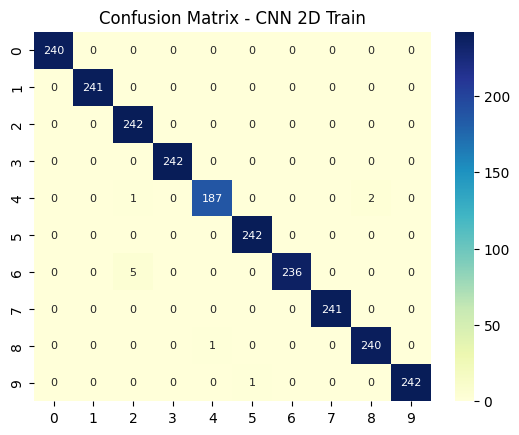

2025-06-18 13:32:21.124483: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-18 13:32:21.124770: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step


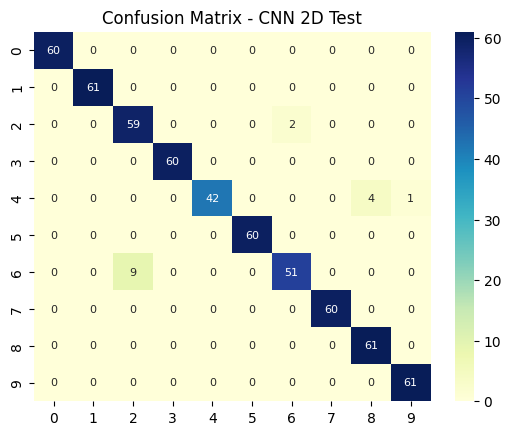

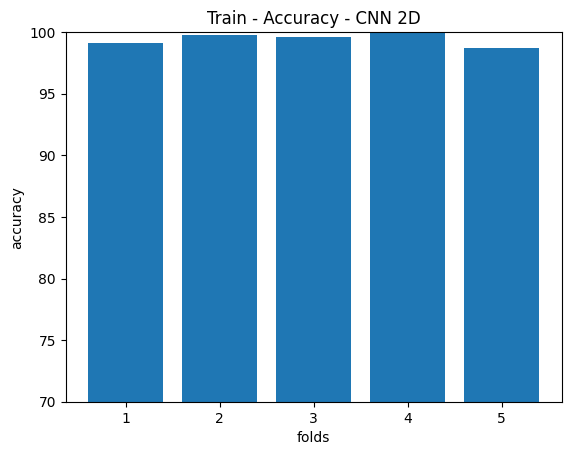

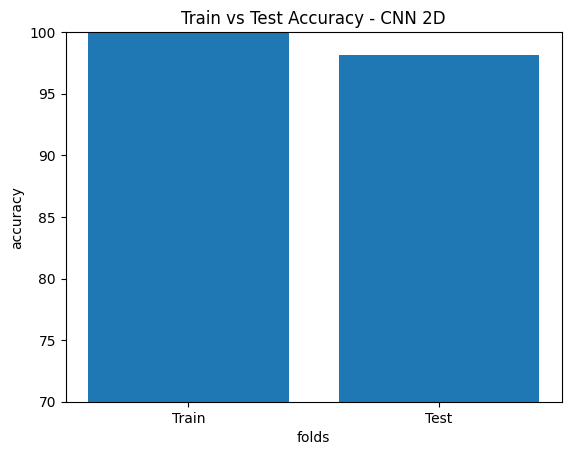

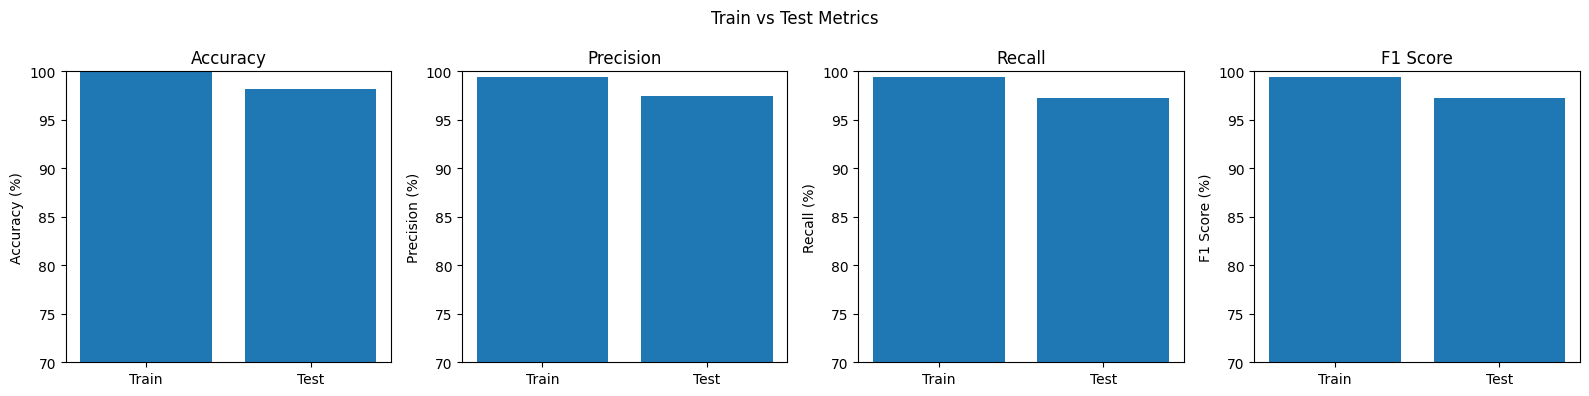

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

CNN_2D_train_accuracy = np.average(accuracy_train) * 100
print(f'CNN 2D train accuracy = {CNN_2D_train_accuracy}')
CNN_2D_val_accuracy = np.average(accuracy_val) * 100
print(f'CNN 2D validation accuracy = {CNN_2D_val_accuracy}')
CNN_2D_test_accuracy = np.average(accuracy_test) * 100
print(f'CNN 2D test accuracy = {CNN_2D_test_accuracy}')

CNN_2D_val_precision = np.average(precision_val) * 100
CNN_2D_val_recall = np.average(recall_val) * 100
CNN_2D_val_f1 = np.average(f1_val) * 100

# Calculate metrics for test set
y_pred_test = np.argmax(CNN_2D_best_model.predict(X_2D_test), axis=1)
y_true_test = np.argmax(y_2D_test, axis=1)
CNN_2D_test_precision = precision_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_recall = recall_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_f1 = f1_score(y_true_test, y_pred_test, average='weighted') * 100


print('CNN 2D Validation Precision = {:.2f}%'.format(CNN_2D_val_precision))
print('CNN 2D Validation Recall = {:.2f}%'.format(CNN_2D_val_recall))
print('CNN 2D Validation F1 Score = {:.2f}%'.format(CNN_2D_val_f1))
print('CNN 2D Test Precision = {:.2f}%'.format(CNN_2D_test_precision))
print('CNN 2D Test Recall = {:.2f}%'.format(CNN_2D_test_recall))
print('CNN 2D Test F1 Score = {:.2f}%'.format(CNN_2D_test_f1))


def ConfusionMatrix(Model, X, y):
    y_pred = np.argmax(Model.predict(X), axis=1)
    ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
    return ConfusionMat

# Plot results
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1, kSplits + 1), [i * 100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70, 100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([70, 100])
plt.show()

# Plot train vs test metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Train vs Test Metrics')

ax1.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Train', 'Test'])
ax1.set_ylim([70, 100])

ax2.bar([1, 2], [CNN_2D_val_precision, CNN_2D_test_precision])
ax2.set_title('Precision')
ax2.set_ylabel('Precision (%)')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Train', 'Test'])
ax2.set_ylim([70, 100])

ax3.bar([1, 2], [CNN_2D_val_recall, CNN_2D_test_recall])
ax3.set_title('Recall')
ax3.set_ylabel('Recall (%)')
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Train', 'Test'])
ax3.set_ylim([70, 100])

ax4.bar([1, 2], [CNN_2D_val_f1, CNN_2D_test_f1])
ax4.set_title('F1 Score')
ax4.set_ylabel('F1 Score (%)')
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Train', 'Test'])
ax4.set_ylim([70, 100])

plt.tight_layout()
plt.show()

## Notes

- **Running the Notebook**: Ensure the CWRU dataset files are in the 'CWRU_BearingData_Load_2HP' folder. Install required libraries (e.g., `pip install PyWavelets` for pywt).
- **Switching Input Types**: Change `image_type` to 'spectrogram' in the main execution cell to use spectrograms instead of scalograms.
- **Performance**: Per Verstraete et al., scalograms achieve up to 99.5% accuracy on CWRU data with 96x96 images, outperforming spectrograms (99.5%) and HHT (97.6%).